itog_model_# библиотеки

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from statsmodels.iolib.table import SimpleTable
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm


from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

from scipy.ndimage.interpolation import shift
from scipy.optimize import minimize
import scipy.stats as scs


from itertools import product
from tqdm import tqdm


# Функции 

In [2]:
def get_mape(y_true, y_pred): 
    """
    Вычислить среднюю абсолютную процентную ошибку (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotMovingAverage(series, n): # Код для отрисовки график метода скользящей средней 

    rolling_mean = series.rolling(window=n).mean() # сглаживание исходного ряда для выявления трендов
    # Чем больше зададим ширину интервала n — тем более сглаженным окажется тренд
    
    # При желании, можно строить и доверительные интервалы для сглаженных значений
    rolling_std =  series.rolling(window=n).std()
    upper_bond = rolling_mean+1.96*rolling_std
    lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(10,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend") # Скользящий средний тренд

    plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bond, "r--")
    plt.plot(series[n:], label="Actual values") # Фактические значения
    plt.legend(loc="upper left")
    plt.grid(True)

def weighted_average(series, weights): # Метод взвешенной средней за последний месяц
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series[-n-1] * weights[n]
    return result

def exponential_smoothing(series, alpha): # Метод экспоненциального сглаживания
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result 

def double_exponential_smoothing(series, alpha, beta): # Метод двойного экспоненциального сглаживания
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'): # Критерий Дики-Фуллера
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        plt.tight_layout()
        
        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1],'< 0.05')

    return 

def invboxcox(y,lmbda):# обратное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

# модуль программы

In [3]:
# загрузка dataset
db = pd.read_csv('SalesX.csv',';', parse_dates=['Date'], index_col='Date', dayfirst=True, low_memory = False) #1,045,311

In [4]:
df2 = db
df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1045311 entries, 2015-08-30 13:17:00 to 2016-06-11 11:52:00
Data columns (total 7 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   ID        1045311 non-null  object 
 1   Category  1045311 non-null  object 
 2   Brand     1045311 non-null  object 
 3   GMV       1045311 non-null  float64
 4   MRP       1045311 non-null  int64  
 5   Units     1045311 non-null  int64  
 6   SLA       1045311 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 63.8+ MB


,ID,Category,Brand,GMV,MRP,Units,SLA
Date,,,,,,,
2015-08-30 13:17:00,ACCE7U2GBCJKQZZV,CameraAccessory,Lens,285.0,395,1,16
2015-09-14 16:06:00,AUDEAFDA5GGESPWX,EntertainmentSmall,AudioMP3Player,299.0,999,1,8
2015-09-15 13:06:00,ACCDH7MFZJGRWJCW,GamingHardware,GamePad,284.0,410,1,5
2015-09-22 11:26:00,VGLE7AUXCYJWGBRV,EntertainmentSmall,VideoGlasses,419.0,349,1,9
2015-09-22 17:17:00,REME69QDWFWZGUMB,EntertainmentSmall,RemoteControl,490.0,999,1,8


In [319]:
#df2[30:1044825].GMV.plot(figsize=(15,8)) # start= 30 end = 1044825

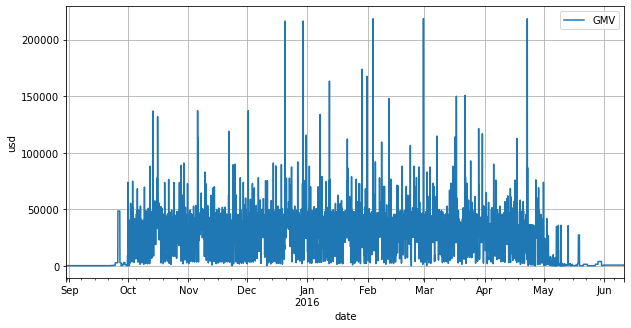

In [5]:
# Объем продаж с 2015-2016г в часах
df = df2[['GMV']].resample('h').max() #df = df[['GMV','MRP']]
df = df.fillna(method='ffill')
df.plot(figsize=(10,5))
plt.legend(loc = 'best')
plt.xlabel("date")
plt.ylabel("usd")
plt.grid(True)

In [6]:
df = df2[['GMV','MRP','SLA','Units']].resample('h').max()
df = df.fillna(method='ffill')

In [7]:
df = pd.DataFrame({'GMV': df.GMV/10,'MRP': df.MRP/10,
                   'SLA': df.SLA,'Units': df.Units
                   })
df

,GMV,MRP,SLA,Units
Date,,,,
2015-08-30 13:00:00,28.5,39.5,16.0,1.0
2015-08-30 14:00:00,28.5,39.5,16.0,1.0
2015-08-30 15:00:00,28.5,39.5,16.0,1.0
2015-08-30 16:00:00,28.5,39.5,16.0,1.0
2015-08-30 17:00:00,28.5,39.5,16.0,1.0
...,...,...,...,...
2016-06-11 07:00:00,77.9,129.9,9.0,1.0
2016-06-11 08:00:00,77.9,129.9,9.0,1.0
2016-06-11 09:00:00,77.9,129.9,9.0,1.0


Text(0.5, 0.98, 'Multiplicative Decomposition')

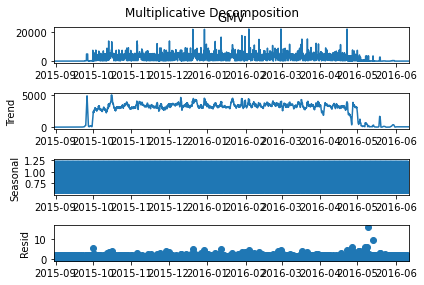

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_results = seasonal_decompose(df.GMV, model="multiplicative")

decomposition_results.plot().suptitle("Multiplicative Decomposition", fontsize=12)

count     6863.000000
mean      2516.652557
std       1979.410563
min         12.900000
25%        285.000000
50%       3049.000000
75%       3663.900000
max      21850.000000
Name: GMV, dtype: float64
V = 0.786525


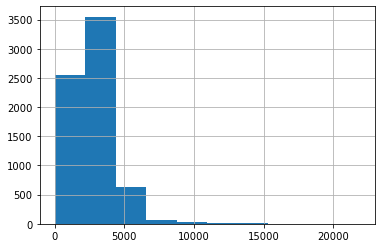

In [9]:
itog_GMV = df.GMV.describe()
print(itog_GMV)
df['GMV'].hist()
print ('V = %f' % (itog_GMV['std']/itog_GMV['mean']))

In [10]:
# сглаживаени сильных выбросов, в данных 
j = 0
l = []
for i in range(0, 6863):
    if df.GMV[i] > 8000: # or df.GMV[i] < 10000:
        df.replace(df.GMV[i], np.nan, inplace=True)
        df.fillna(method='ffill',inplace=True )
        j+=1
        l.append(i)
df.dropna(inplace=True)

Text(0, 0.5, 'usd')

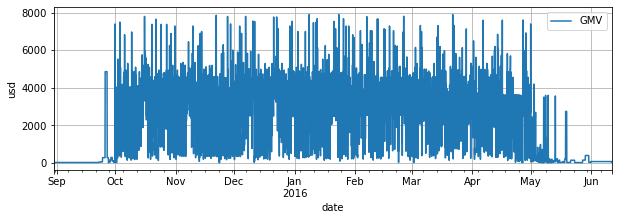

In [11]:
df.GMV.plot(figsize=(10,3), grid = True)
plt.legend(loc = 'best')
plt.xlabel("date")
plt.ylabel("usd")

In [18]:
test = sm.tsa.adfuller(df.GMV)
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -3.429837870151002
p-value:  0.009982793824942125
Critical values:  {'1%': -3.431307657594668, '5%': -2.8619632060722413, '10%': -2.5669952688059707}
единичных корней нет, ряд стационарен


In [32]:
# #Сохранение нового файла 
# df.to_csv('приложение А.csv', sep=';', encoding='utf-8')

# Методы скользаящей 

In [12]:
def moving_average(series, n):           # Метод скользящей средней за последний день
    return np.average(series[-n:])
print(moving_average(df.GMV[5147:5868], 24)) # среднее за последние 24 часа

3082.0916666666667


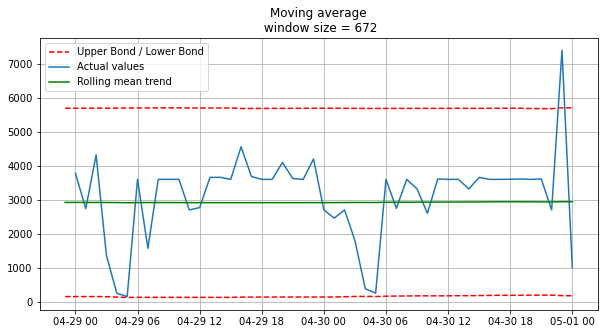

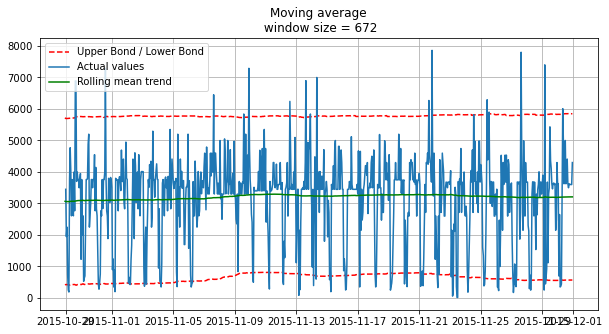

In [277]:
def plotMovingAverage(series, n): # Код для отрисовки график метода скользящей средней 

    rolling_mean = series.rolling(window=n).mean() # сглаживание исходного ряда для выявления трендов
    # Чем больше зададим ширину интервала n — тем более сглаженным окажется тренд
    
    # При желании, можно строить и доверительные интервалы для сглаженных значений
    rolling_std =  series.rolling(window=n).std()
    upper_bond = rolling_mean+1.96*rolling_std
    lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(10,5))
    plt.title("Moving average\n window size = {}".format(n))
    
    plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bond, "r--")
    plt.plot(series[n:], label="Actual values") # Фактические значения
    plt.plot(rolling_mean, "g", label="Rolling mean trend") # Скользящий средний тренд

    plt.legend(loc="upper left")
    plt.grid(True)
    
# График метод скользящей средней 

plotMovingAverage(df.GMV[5147:5868], 24*7*4) # сглаживаем по дню
plotMovingAverage(df.GMV[755:2219], 24*7*4) # сглаживаем по месяцу


In [21]:
#Метод взвешенной средней 
def weighted_average(series, weights):
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series[-n-1] * weights[n]
    return result

print(weighted_average(df.GMV[5147:5868], [0.8, 0.1, 0.05, 0.04, 0.01]))

3682.174


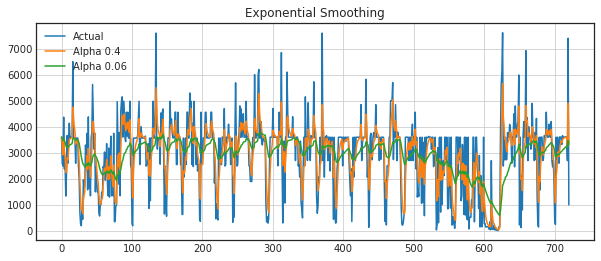

In [282]:
# Простое экспоненциальное сглаживание 

with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(10, 4))
    plt.plot(df.GMV[5147:5868].values, label = "Actual")
    for alpha in [0.4, 0.06]:
        plt.plot(exponential_smoothing(df.GMV[5147:5868], alpha), label="Alpha {}".format(alpha))

    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

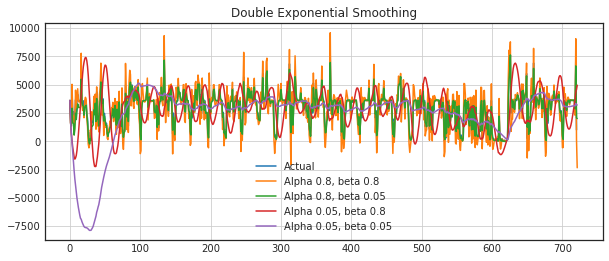

In [283]:
# Двойное экспоненциальное сглаживание 

with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(10, 4))
    plt.plot(df.GMV[5147:5868].values, label = "Actual") 
    for alpha in [0.8, 0.05]:
        for beta in [0.8, 0.05]:
            plt.plot(double_exponential_smoothing(df.GMV[5147:5868], alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))

    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

# Эконометрические модели

Критерий Дики-Фуллера: p=0.009983 < 0.05


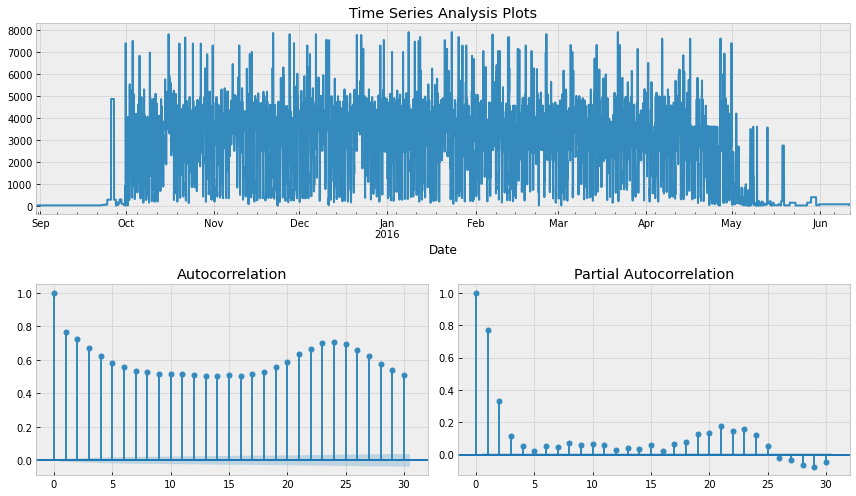

In [13]:
tsplot(df.GMV, lags=30)

Оптимальный параметр преобразования Бокса-Кокса: 0.521195
Критерий Дики-Фуллера: p=0.026532 < 0.05


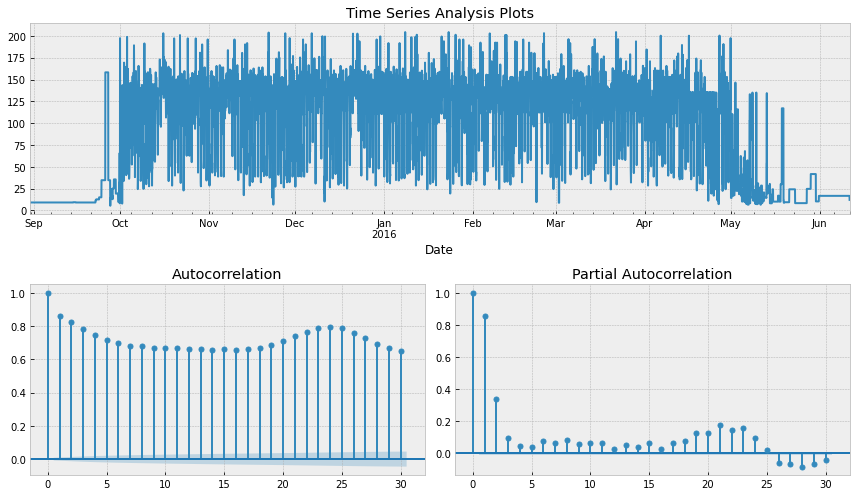

In [14]:
data = df.copy()
data['GMV_'] = data['GMV']
data['GMV'], lmbda = scs.boxcox(data.GMV)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
tsplot(data.GMV, lags=30)
#data.drop(['GMV'], axis=1, inplace=True)

Критерий Дики-Фуллера: p=0.000000 < 0.05


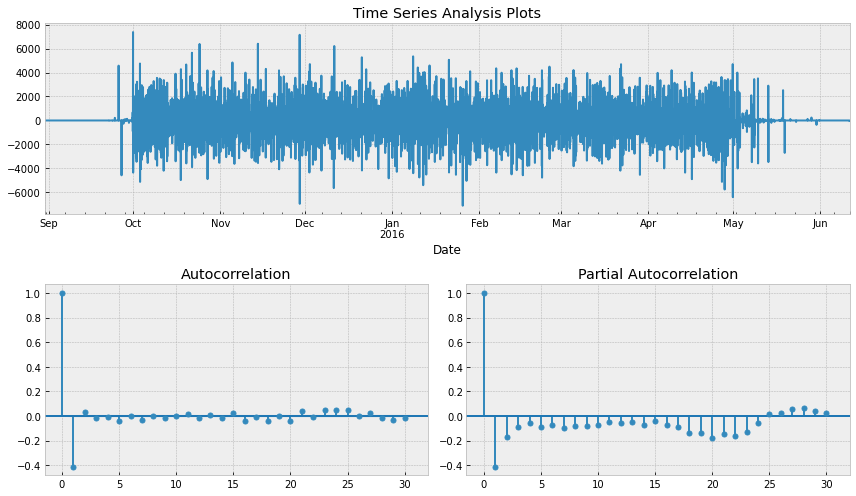

In [15]:
data['GMV_1'] = data.GMV_ - data.GMV_.shift(1)
tsplot(data.GMV_1[1:], lags=30)

#data['GMV_2'] = data.GMV_1 - data.GMV_1.shift(1)
#tsplot(data.GMV_2[24*7+1:], lags=30)

#data['GMV_3'] = data.GMV_2 - data.GMV_2.shift(1)
#tsplot(data.GMV_3[24*7+2:], lags=30)

#data['GMV_4'] = data.GMV_3 - data.GMV_3.shift(1)
#tsplot(data.GMV_4[24*7+3:], lags=30)

count    6863.000000
mean       96.960778
std        54.571476
min         5.356346
25%        34.594825
50%       123.254560
75%       136.008629
max       204.344666
Name: GMV, dtype: float64
V = 0.562820


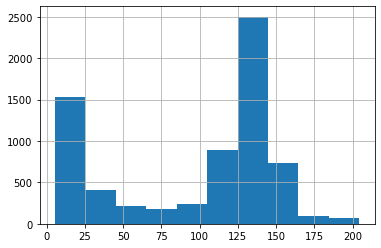

In [16]:
itog_GMV = data.GMV.describe()
data.GMV.hist()
print(itog_GMV)
print ('V = %f' % (itog_GMV['std']/itog_GMV['mean']))

In [19]:
data

,GMV,MRP,SLA,Units,GMV_,GMV_1
Date,,,,,,
2015-08-30 13:00:00,9.077921,39.5,16.0,1.0,28.5,NaN
2015-08-30 14:00:00,9.077921,39.5,16.0,1.0,28.5,0.0
2015-08-30 15:00:00,9.077921,39.5,16.0,1.0,28.5,0.0
2015-08-30 16:00:00,9.077921,39.5,16.0,1.0,28.5,0.0
2015-08-30 17:00:00,9.077921,39.5,16.0,1.0,28.5,0.0
...,...,...,...,...,...,...
2016-06-11 07:00:00,16.653395,129.9,9.0,1.0,77.9,0.0
2016-06-11 08:00:00,16.653395,129.9,9.0,1.0,77.9,0.0
2016-06-11 09:00:00,16.653395,129.9,9.0,1.0,77.9,0.0


In [20]:
# добавление доп. признаков
data["date"] = data.index.date
#df["hour"] = df.index.hour
#df["day"] = df.index.day
#df["weekday"] = df.index.weekday
#df['is_weekend'] = df.weekday.isin([5,6])*1
#df["month"] = df.index.month
#df = df.drop(["weekday"],1)
# Вычислим разницу между 
data['range_mg'] = data.MRP - data.GMV_ 
#data.drop(['Units'], axis=1, inplace=True)
data.head()

,GMV,MRP,SLA,Units,GMV_,GMV_1,date,range_mg
Date,,,,,,,,
2015-08-30 13:00:00,9.077921,39.5,16.0,1.0,28.5,NaN,2015-08-30,11.0
2015-08-30 14:00:00,9.077921,39.5,16.0,1.0,28.5,0.0,2015-08-30,11.0
2015-08-30 15:00:00,9.077921,39.5,16.0,1.0,28.5,0.0,2015-08-30,11.0
2015-08-30 16:00:00,9.077921,39.5,16.0,1.0,28.5,0.0,2015-08-30,11.0
2015-08-30 17:00:00,9.077921,39.5,16.0,1.0,28.5,0.0,2015-08-30,11.0


In [17]:
# Подбор параметров модели ARIMA 

# начальное приближение параметров 
# Q=3, P=4, q=1, p=1

ps = range(0, 2)
d  = 1
qs = range(0, 2)
Ps = range(0, 3)
D  = 1
Qs = range(0, 3)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [412]:
# таймер 
#%time
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.GMV, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
        
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  3%|▎         | 1/36 [00:44<25:48, 44.23s/it]


MemoryError: Unable to allocate 131. MiB for an array with shape (50, 50, 6864) and data type float64

In [21]:
#%time
best_model = sm.tsa.statespace.SARIMAX(data.GMV, order=(2,1,1),
                                      seasonal_order=(0,1,1, 24)).fit(disp=-1)

In [22]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                GMV   No. Observations:                 6863
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 24)   Log Likelihood              -31196.650
Date:                            Wed, 23 Jun 2021   AIC                          62403.300
Time:                                    18:02:16   BIC                          62437.451
Sample:                                08-30-2015   HQIC                         62415.082
                                     - 06-11-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2079      0.008     25.160      0.000       0.192       0.224
ar.L2          0.1355      0.009   

Критерий Дики-Фуллера: p=0.000000 < 0.05


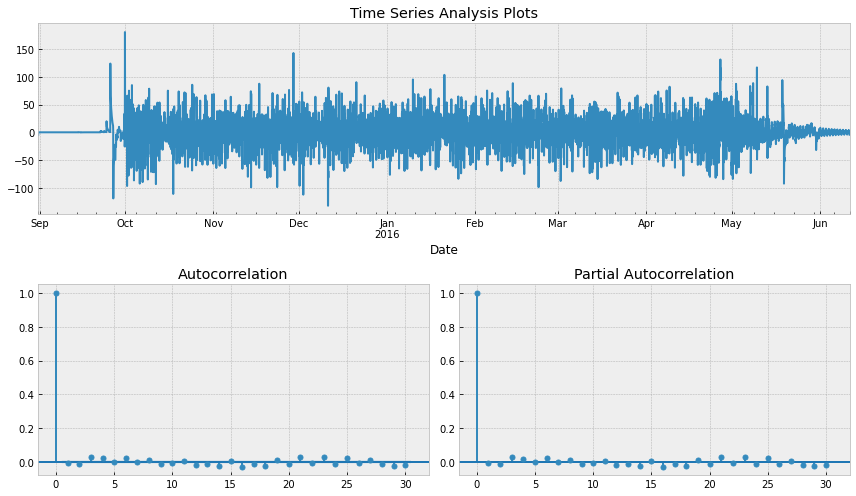

In [23]:
tsplot(best_model.resid[24:], lags=30)

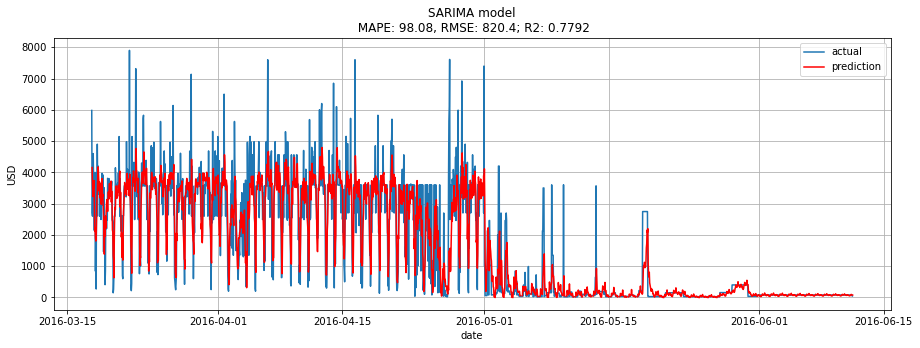

In [24]:
#график прогноза 


data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)

forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]), lmbda)
forecast = data["arima_model"].append(forecast)[-2058:]
#print(list(forecast))
      
actual = data.GMV_[-2058:]

plt.figure(figsize=(15, 5))
plt.plot(actual, label="actual")
plt.plot(forecast, 'r', label="prediction") 
plt.legend(loc = 'best')
plt.xlabel("date")
plt.ylabel("USD")
#plt.title("SARIMA model\n Mean absolute error {} GMV".format
#          (round(mean_absolute_error(data.dropna().GMV_, data.dropna().arima_model))))
plt.title("SARIMA model\n MAPE: {:.4}, RMSE: {:.4}; R2: {:.4}".format(
     get_mape(data.dropna().GMV_[-2058:], data.dropna().arima_model[-2058:]),
     np.sqrt(mean_squared_error(data.dropna().GMV_[-2058:], data.dropna().arima_model[-2058:])),
     r2_score(data.dropna().GMV_[-2058:], data.dropna().arima_model[-2058:])))

plt.grid(True)

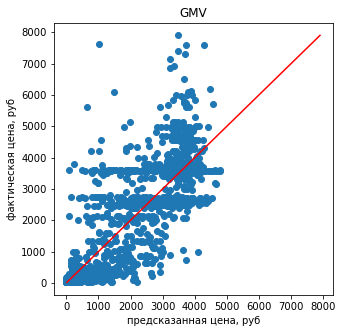

In [25]:
plt.figure(figsize=(5, 5))
plt.scatter(data.dropna().arima_model[-2058:],data.dropna().GMV_[-2058:])
plt.title("GMV")
plt.ylabel('фактическая цена, руб')
plt.xlabel('предсказанная цена, руб')
plt.plot([data.dropna().GMV_.min(), data.dropna().GMV_.max()],[[data.dropna().GMV_.min()],[data.dropna().GMV_.max()]], color = 'red')

In [304]:
itog_model = pd.DataFrame({'SARIMA': forecast})
#Сохранение нового файла 
itog_model.to_csv('itog_model_SARIMA.csv', sep=';', encoding='utf-8')

In [26]:
db1 = pd.read_csv('itog_model_SARIMA.csv',';', parse_dates=['Date'], index_col='Date', dayfirst=True, low_memory = False)

In [27]:
db2 = pd.read_csv('itog_model_LR.csv',';', parse_dates=['Date'], index_col='Date', dayfirst=True, low_memory = False)

In [28]:
db3 = pd.read_csv('itog_model_XGBOOST.csv',';', parse_dates=['Date'], index_col='Date', dayfirst=True, low_memory = False)

In [29]:
db4 = pd.read_csv('itog_model_LSTM.csv',';', parse_dates=['Date'], index_col='Date', dayfirst=True, low_memory = False)

In [30]:
itog_model_ = pd.DataFrame({'XGBOOST': np.array(db3.XGBOOST).reshape(-1),
                            'SARIMA': forecast,
                            'LR': db2.LR[1:],
                            'LSTM': np.array(db4.LSTM),
                            'GMV': actual[1:]
                           })

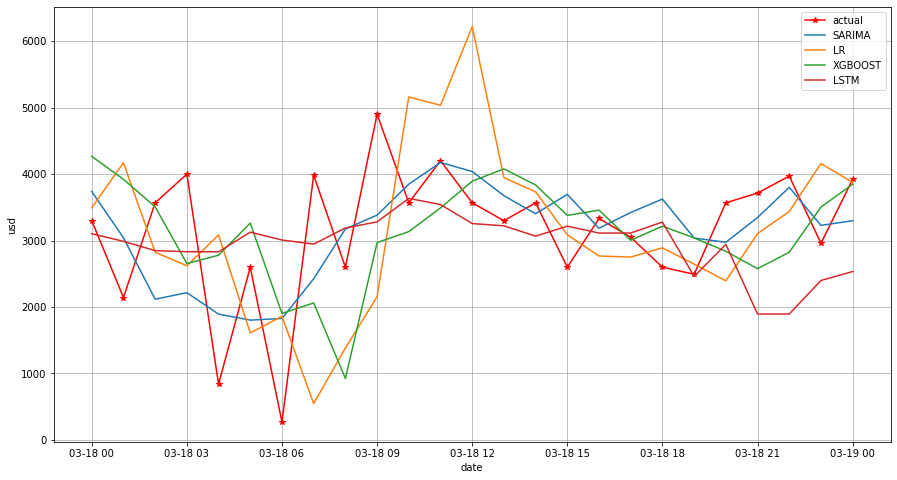

In [70]:
plt.figure(figsize=(15, 8))


plt.plot(itog_model_['GMV'][5:30], 'r-*', label="actual"  )

plt.plot(itog_model_['SARIMA'][5:30], label="SARIMA"  )
plt.plot(itog_model_['LR'][5:30], label="LR"  )
plt.plot(itog_model_['XGBOOST'][5:30], label="XGBOOST"  )
plt.plot(itog_model_['LSTM'][5:30], label="LSTM"  )
plt.xlabel("date")
plt.ylabel("usd")
plt.legend(loc = 'best')
plt.grid(True)

In [68]:
itog_model_[5:30]

,XGBOOST,SARIMA,LR,LSTM,GMV
2016-03-18 00:00:00,4266.594144,3737.543270,3493.007496,3101.903264,3299.0
2016-03-18 01:00:00,3921.601009,3041.786602,4169.786136,2988.281815,2143.1
2016-03-18 02:00:00,3507.265918,2117.302209,2824.035616,2848.331174,3567.5
2016-03-18 03:00:00,2653.474666,2216.059259,2620.338295,2831.798142,3999.0
2016-03-18 04:00:00,2779.149746,1893.390032,3084.199547,2830.969040,839.9
2016-03-18 05:00:00,3262.733802,1802.811684,1610.880946,3125.686008,2599.0
2016-03-18 06:00:00,1903.256780,1827.779408,1860.443159,3007.916278,269.9
2016-03-18 07:00:00,2061.202110,2424.449549,547.746122,2946.292436,3983.2
2016-03-18 08:00:00,924.958285,3174.137288,1382.900131,3188.562574,2599.0
2016-03-18 09:00:00,2969.540916,3382.149515,2154.837147,3280.811971,4900.5
